# IBM 人员流失预测

## Introduction

保持雇员的快乐和对公司满意度是一个古老的挑战，如果你对雇员投资了很多，而他却离开了，这意味着你还要花费更多时间雇用别人，本着 Kaggle 的精神，让我们构建一个预测模型来根据 IBM 的数据集预测 IBM 员工的流失

这个笔记包括以下内容：

  1. Exploratory Data Analysis: 在这个章节，我们探索数据集分布特征，特征间如何对应并可视化
  2. Feature Engineering and Categorical Encoding: 进行一些特征工程并将我们的的特征编码为多个变量
  3. Implementing Machine Learning models: 我们实现一个随机森林和梯度增强模型，然后看在这些模型中特征的重要性
 
Let's Go.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import statements required for Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from imblearn.over_sampling import SMOTE
import xgboost

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

/home/kaka/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



## 1. Exploratory Data Analysis

让我们通过 Pandas 加载 datasets，我们快速看一下前几行，重点的关注是 attrition

In [2]:
attrition = pd.read_csv('./inputs/WA_Fn-UseC_-HR-Employee-Attrition.csv')
attrition.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


从数据集中看，我们的目标列是 `Attrition`

此外，我们的数据是类型和数字数据混合的，对于这些非数字的类别，我们后面会将其编码成数字，这里我们首先探索数据集，首先检查一下数据集的完整性，简单的检查一下数据集中有没有空的或者无穷的数据

### Data quality checks

可以使用 `isnull()` 函数来看有没有空的数据

In [3]:
#Looking for NaN
attrition.isnull().any()

Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesL

### Distribution of the dataset

一般前几步会探索数据集特征如何分布，为了实现这个，我们调用 Seaborn plotting 库中的 kdeplot() 函数并且生成双变量图如下:

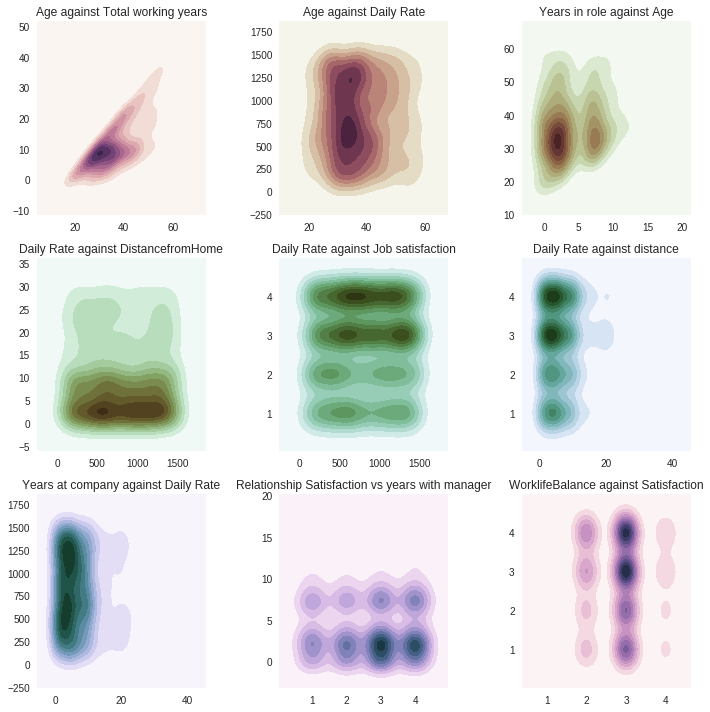

In [4]:
# Plotting the KDEplots
f, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=False, sharey=False)

# Defining our colormap scheme
# s本来想调颜色的，后来都手工指定了 0.333....
#s = np.linspace(0, 3, 10) # [0,3] 区间等间隔生成 10 个数
# 创建一系列调色板，light 是调色板的最浅颜色的强度，１表示最强，
# as_cmap 为真表示使用 matplotlib 颜色表
cmap = sns.cubehelix_palette(start=0.0, light=1, as_cmap=True)

# Generate and plot
x = attrition['Age'].values
y = attrition['TotalWorkingYears'].values
# 画出单变量或双变量核密度预测, shade=True 表示数据是双变量时候填充轮廓
# cut=5 表示从每个内核的极端数据点切去几个 bw (带宽, 也是 kdeplot 的参数，作用控制估计与数据的拟合程度)
# cut 越大，整个图像越小数据越密集
# ax 参数指定在哪个轴上绘制，默认使用当前轴
sns.kdeplot(x, y, cmap=cmap, shade=True, cut=5, ax=axes[0,0])
axes[0,0].set( title = 'Age against Total working years')

cmap = sns.cubehelix_palette(start=0.333333333333, light=1, as_cmap=True)
# Generate and plot
x = attrition['Age'].values
y = attrition['DailyRate'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[0,1])
axes[0,1].set( title = 'Age against Daily Rate')

cmap = sns.cubehelix_palette(start=0.666666666667, light=1, as_cmap=True)
# Generate and plot
x = attrition['YearsInCurrentRole'].values
y = attrition['Age'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[0,2])
axes[0,2].set( title = 'Years in role against Age')

cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)
# Generate and plot
x = attrition['DailyRate'].values
y = attrition['DistanceFromHome'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[1,0])
axes[1,0].set( title = 'Daily Rate against DistancefromHome')

cmap = sns.cubehelix_palette(start=1.333333333333, light=1, as_cmap=True)
# Generate and plot
x = attrition['DailyRate'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[1,1])
axes[1,1].set( title = 'Daily Rate against Job satisfaction')

cmap = sns.cubehelix_palette(start=1.666666666667, light=1, as_cmap=True)
# Generate and plot
x = attrition['YearsAtCompany'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[1,2])
axes[1,2].set( title = 'Daily Rate against distance')

cmap = sns.cubehelix_palette(start=2.0, light=1, as_cmap=True)
# Generate and plot
x = attrition['YearsAtCompany'].values
y = attrition['DailyRate'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[2,0])
axes[2,0].set( title = 'Years at company against Daily Rate')

cmap = sns.cubehelix_palette(start=2.333333333333, light=1, as_cmap=True)
# Generate and plot
x = attrition['RelationshipSatisfaction'].values
y = attrition['YearsWithCurrManager'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[2,1])
axes[2,1].set( title = 'Relationship Satisfaction vs years with manager')

cmap = sns.cubehelix_palette(start=2.666666666667, light=1, as_cmap=True)
# Generate and plot
x = attrition['WorkLifeBalance'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[2,2])
axes[2,2].set( title = 'WorklifeBalance against Satisfaction')

f.tight_layout()

In [5]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
attrition["Attrition_numerical"] = attrition["Attrition"].apply(lambda x: target_map[x])

In [6]:
attrition

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_numerical
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,80,0,8,0,1,6,4,0,5,1
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,80,1,10,3,3,10,7,1,7,0
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,80,0,7,3,3,0,0,0,0,1
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,80,0,8,3,3,8,7,3,0,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,80,1,6,3,3,2,2,2,2,0
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,80,0,8,2,2,7,7,3,6,0
6,59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,...,80,3,12,3,2,1,0,0,0,0
7,30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,...,80,1,1,2,3,1,0,0,0,0
8,38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,...,80,0,10,2,3,9,7,1,8,0
9,36,No,Travel_Rarely,1299,Research & Development,27,3,Medical,1,13,...,80,2,17,3,2,7,7,7,7,0


### Correlation of Features

接下来的探索工具是关于矩阵的，通过绘制相关矩阵，我们可以很好的描述特征之间的关联，在 Pandas dataframe 中，我们可以使用 corr 函数可以为 dataframe 的每对列数据提供皮尔森相关系数（也叫矩阵相关系数，用来反映两个变量线性相关程度的统计量）

在这里，我将使用 Plotly 库中的 Heatmap() 函数绘出皮尔森相关系数矩阵:

In [7]:
# creating a list of only numerical values
numerical = [u'Age', u'DailyRate', u'DistanceFromHome', u'Education', u'EmployeeNumber', u'EnvironmentSatisfaction',
       u'HourlyRate', u'JobInvolvement', u'JobLevel', u'JobSatisfaction',
       u'MonthlyIncome', u'MonthlyRate', u'NumCompaniesWorked',
       u'PercentSalaryHike', u'PerformanceRating', u'RelationshipSatisfaction',
       u'StockOptionLevel', u'TotalWorkingYears',
       u'TrainingTimesLastYear', u'WorkLifeBalance', u'YearsAtCompany',
       u'YearsInCurrentRole', u'YearsSinceLastPromotion',
       u'YearsWithCurrManager']
data = [
    go.Heatmap(
        z= attrition[numerical].astype(float).corr().values, # Generating the Pearson correlation
        x=attrition[numerical].columns.values,
        y=attrition[numerical].columns.values,
        colorscale='Viridis',
        reversescale = False, #反转色域
        text = True,
        opacity = 1.0 #不透明度
        
    )
]


layout = go.Layout(
    title='Pearson Correlation of numerical features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700,
    
)


fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

### Takeaway from the plots

从上图中，我们可以看到有相当多的列好像彼此关系很差，一般来说，做一个预测模型，我们的训练数据最好彼此不相关，因为我们不需要冗余数据，在这个例子中，在我们有相当多的相关特征情况下，或许我们应该应用 PCA（Principal Component Analysis --> 主成分分析）来减少特征空间

### Pairplot Visualisations

现在让我们创建一些 Seaborn pairplot 并且设置 Attrition 列作为目标变量得到各个特征分布对人员流失的影响

In [8]:
# Refining our list of numerical variables
numerical = [u'Age', u'DailyRate',  u'JobSatisfaction',
       u'MonthlyIncome', u'PerformanceRating',
        u'WorkLifeBalance', u'YearsAtCompany', u'Attrition_numerical']

#g = sns.pairplot(attrition[numerical], hue='Attrition_numerical', palette='seismic', diag_kind = 'kde',diag_kws=dict(shade=True))
#g.set(xticklabels=[])

## 2. Feature Engineering & Categorical Encoding

我们对数据集进行了简单的探索，现在我们处理特征工程和对分类进行数字编码，特征工程简单地说就是从已有的特征创建新的特征关系，特征工程非常重要。

在开始之前，我们使用 dtype 方法将数字和分类隔离

In [9]:
attrition

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_numerical
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,80,0,8,0,1,6,4,0,5,1
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,80,1,10,3,3,10,7,1,7,0
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,80,0,7,3,3,0,0,0,0,1
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,80,0,8,3,3,8,7,3,0,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,80,1,6,3,3,2,2,2,2,0
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,80,0,8,2,2,7,7,3,6,0
6,59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,...,80,3,12,3,2,1,0,0,0,0
7,30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,...,80,1,1,2,3,1,0,0,0,0
8,38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,...,80,0,10,2,3,9,7,1,8,0
9,36,No,Travel_Rarely,1299,Research & Development,27,3,Medical,1,13,...,80,2,17,3,2,7,7,7,7,0


In [10]:
# Drop the Attrition_numerical column from attrition dataset first - Don't want to include that
attrition = attrition.drop(['Attrition_numerical'], axis=1)

# Empty list to store columns with categorical data
categorical = []
for col, value in attrition.iteritems():
    if value.dtype == 'object':
        categorical.append(col)

# Store the numerical columns in a list numerical
print(categorical)
numerical = attrition.columns.difference(categorical)

['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']


In [11]:
numerical

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

确定我们的特征包含分类数据，我们可以将 numerical 编码，可以使用 Pandas 的 get_dummies() 方法

In [17]:
# Store the categorical data in a dataframe called attrition_cat
attrition_cat = attrition[categorical] #提取出不是数字的列
attrition_cat = attrition_cat.drop(['Attrition'], axis=1) # Dropping the target column
print(attrition_cat)

         BusinessTravel              Department    EducationField  Gender  \
0         Travel_Rarely                   Sales     Life Sciences  Female   
1     Travel_Frequently  Research & Development     Life Sciences    Male   
2         Travel_Rarely  Research & Development             Other    Male   
3     Travel_Frequently  Research & Development     Life Sciences  Female   
4         Travel_Rarely  Research & Development           Medical    Male   
5     Travel_Frequently  Research & Development     Life Sciences    Male   
6         Travel_Rarely  Research & Development           Medical  Female   
7         Travel_Rarely  Research & Development     Life Sciences    Male   
8     Travel_Frequently  Research & Development     Life Sciences    Male   
9         Travel_Rarely  Research & Development           Medical    Male   
10        Travel_Rarely  Research & Development           Medical    Male   
11        Travel_Rarely  Research & Development     Life Sciences  Female   

应用 get_dummies() 方法自动编码, 我们可以很方便的用以下代码看编码后的结果

In [18]:
attrition_cat = pd.get_dummies(attrition_cat)
attrition_cat.head(3)

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,1,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1


提取出是数字的列

In [19]:
# Store the numerical features to a dataframe attrition_num
attrition_num = attrition[numerical]

我们编码了非数字的变量，并将数字的提取出来，现在我们要将它们合并成最终的训练数据

In [20]:
# Concat the two dataframes together columnwise
attrition_final = pd.concat([attrition_num, attrition_cat], axis=1)

### Target variable

最后，我们需要目标变量, 由 attrition 列给出，我们需要将其编码，１ 代表 Yes, 0 代表 No

In [22]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
target = attrition["Attrition"].apply(lambda x: target_map[x])
target.head(3)

0    1
1    0
2    1
Name: Attrition, dtype: int64

然而，如果检查 Yes 和 No 的数量就会发现，数据有非常大的偏差

In [23]:
data = [go.Bar(
            x=attrition["Attrition"].value_counts().index.values,
            y= attrition["Attrition"].value_counts().values
    )]

py.iplot(data, filename='basic-bar')

因此，我们现在的数据是不平衡的，有很多方法可以解决数据不平衡的问题，在这里我们使用 SMOTE 过采样技术来处理不平衡

## Implementing Machine Learning Models

进行了一些探索分析和简单的特征工程，确保我们的所有的数据都被编码，我们现在可以建立自己的模型

在这个笔记一开始时，我们说我们的目标是为了评估和对比一些不同模型的表现

### 分离和测试数据

在我们训练数据之前，需要有一个训练集和测试集，不同于 Kaggle 比赛，一般我们都会有现成的训练集和测试集，这里我们使用 sklearn 来分离数据

In [24]:
# Import the train_test_split method
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit

# Split data into train and test sets as well as for validation and testing
train, test, target_train, target_val = train_test_split(attrition_final, target, train_size= 0.75,random_state=0);
#train, test, target_train, target_val = StratifiedShuffleSplit(attrition_final, target, random_state=0);